In [1]:
import kagglehub
import pandas as pd
import numpy as np
import warnings
 # Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)

c:\Users\Usuario\Downloads\Automações\Privacidade_Diferencial_rr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Usuario\.cache\kagglehub\datasets\wenruliu\adult-income-dataset\versions\2


In [2]:
warnings.filterwarnings('ignore')
df = pd.read_csv(fr'{path}/adult.csv')
df['id_fixo'] = df.index # cria indices para garantir a mesma resposta sempre a mesma linha
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,id_fixo
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,1
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,2
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,3
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,48837
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,48838
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,48839
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,48840


In [3]:
# consultar real
consulta = df[df.income == '>50K']
maior_que_50  = len(consulta)
menor_que_50 =  len(df) - maior_que_50
print('Indivíduos (>50k): ', maior_que_50)
print('Indivíduos (<=50k): ', menor_que_50)

Indivíduos (>50k):  11687
Indivíduos (<=50k):  37155


In [4]:
import pandas as pd
import numpy as np

# --- PREPARAÇÃO DOS DADOS ---
# Garante que não existam espaços em branco nas strings (ex: ' >50K' vira '>50K')
df['income'] = df['income'].str.strip()

def aplicar_rr(valor_real_str, p, q):
    """
    Aplica o mecanismo de Randomized Response padrão.
    """
    # Converte a resposta real para binário (1 para Sim, 0 para Não)
    valor_real = 1 if valor_real_str == '>50K' else 0

    # --- PRIMEIRA MOEDA (Probabilidade p de dizer a verdade) ---
    if np.random.random() < p:
        return valor_real
    else:
        # --- SEGUNDA MOEDA (Decide a resposta aleatória com prob q) ---
        return 1 if np.random.random() < q else 0

# 2. Estimador Desenviesado (Fórmula da Seção 4.3 do PDF)
def estimador_tendencioso(S, n, p, q):
    if p == 0:
        return 0
    return (S - n * (1 - p) * q) / p

# 3. Experimento
def executar_experimento(df, p, q, n_vezes=10):
    n = len(df)
    valor_real_total = (df['income'] == '>50K').sum()
    estimativas = []

    for _ in range(n_vezes):
        # Aplica o RR para cada linha do dataset usando a coluna income
        respostas_perturbadas = df['income'].apply(lambda x: aplicar_rr(x, p, q))
        S = respostas_perturbadas.sum()

        # Calcula a estimativa usando a fórmula matemática correta
        T_hat = estimador_tendencioso(S, n, p, q)
        estimativas.append(T_hat)

    # Cálculo do Erro Absoluto Médio (MAE)
    media_estimativas = np.mean(estimativas)
    mae = np.mean([abs(est - valor_real_total) for est in estimativas])

    return media_estimativas, mae, valor_real_total

# --- EXECUÇÃO ---

# Cenário 1: Moedas Justas (Seção 3 do PDF)
p_justo, q_justo = 0.5, 0.5

# Cenário 2: Moedas Tendenciosas (Seção 4 do PDF)
# Escolhemos p=0.8 para maior utilidade e q=0.5 para ruído equilibrado
p_tend, q_tend = 0.8, 0.3

est_j, mae_j, real = executar_experimento(df, p_justo, q_justo)
est_t, mae_t, _ = executar_experimento(df, p_tend, q_tend)

print(f"Valor Real (Ground Truth): {real}")
print("-" * 40)
print(f"MOEDAS JUSTAS (p=0.5, q=0.5):")
print(f"  Estimativa Média: {est_j:.2f}")
print(f"  Erro (MAE): {mae_j:.2f}")
print("-" * 40)
print(f"MOEDAS TENDENCIOSAS (p={p_tend}, q={q_tend}):")
print(f"  Estimativa Média: {est_t:.2f}")
print(f"  Erro (MAE): {mae_t:.2f}")

Valor Real (Ground Truth): 11687
----------------------------------------
MOEDAS JUSTAS (p=0.5, q=0.5):
  Estimativa Média: 11768.00
  Erro (MAE): 173.80
----------------------------------------
MOEDAS TENDENCIOSAS (p=0.8, q=0.3):
  Estimativa Média: 11689.98
  Erro (MAE): 33.12


Total de registros (n): 48842
Valor Real de pessoas >50K: 11687


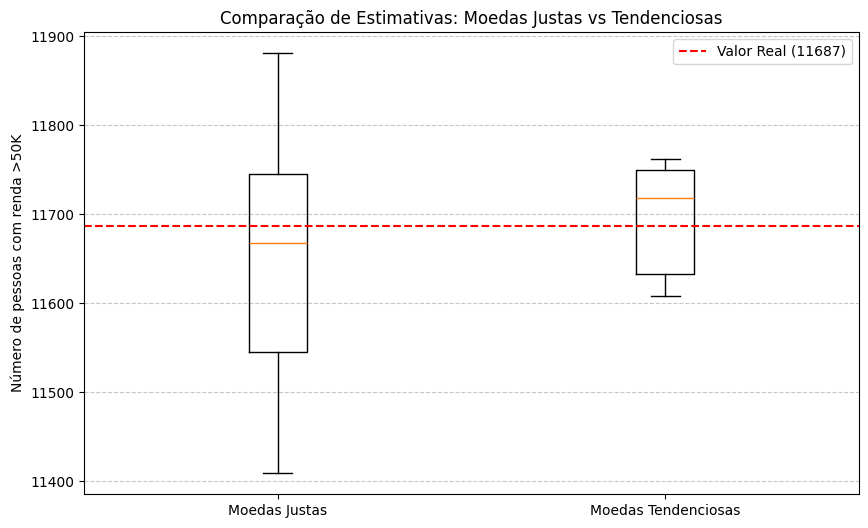

MAE Justas: 118.60
MAE Tendenciosas: 56.93


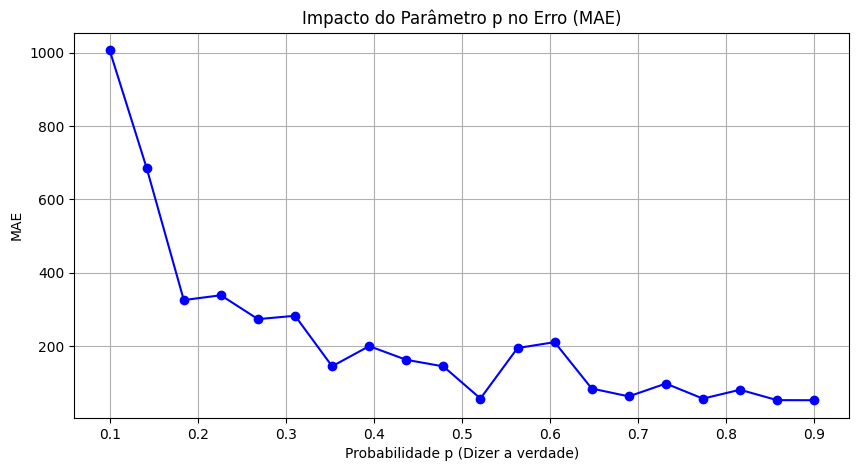

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Preparação dos Dados ---
# Removendo espaços em branco das strings para evitar erros de comparação
df['income'] = df['income'].str.strip()

valor_real_total = (df['income'] == '>50K').sum()
n = len(df)

print(f"Total de registros (n): {n}")
print(f"Valor Real de pessoas >50K: {valor_real_total}")

# --- 2. Função do Mecanismo Corrigida ---
def simulacao_rr(p, q, execucoes=10):
    estimativas = []
    for _ in range(execucoes):
        # CORREÇÃO: O mecanismo agora olha para o valor real 'x'
        def aplicar_rr(x):
            verdade = 1 if x == '>50K' else 0
            if np.random.random() < p:
                return verdade  # Moeda 1 deu Cara: diz a verdade
            else:
                return 1 if np.random.random() < q else 0 # Moeda 1 deu Coroa: joga Moeda 2

        respostas = df['income'].apply(aplicar_rr)
        S = respostas.sum()

        # Aplicando o estimador tendencioso
        T_hat = (S - n * (1 - p) * q) / p
        estimativas.append(T_hat)
    return estimativas

# --- 3. Execução dos Experimentos ---
# Moedas Justas: p=0.5, q=0.5
# Moedas Tendenciosas: p=0.8, q=0.2 (ou os valores que você escolher)
est_justas = simulacao_rr(0.5, 0.5, 10)
est_tendenciosas = simulacao_rr(0.8, 0.2, 10)

# Cálculo do MAE
mae_justas = np.mean([abs(e - valor_real_total) for e in est_justas])
mae_tendenciosas = np.mean([abs(e - valor_real_total) for e in est_tendenciosas])

# --- 4. Gráfico Boxplot ---
plt.figure(figsize=(10,6))
plt.boxplot([est_justas, est_tendenciosas], labels=['Moedas Justas', 'Moedas Tendenciosas'])
plt.axhline(y=valor_real_total, color='r', linestyle='--', label=f'Valor Real ({valor_real_total})')
plt.title('Comparação de Estimativas: Moedas Justas vs Tendenciosas')
plt.ylabel('Número de pessoas com renda >50K')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"MAE Justas: {mae_justas:.2f}")
print(f"MAE Tendenciosas: {mae_tendenciosas:.2f}")

# --- 5. Simulação de Variação de P (Para o segundo gráfico) ---
valores_p = np.linspace(0.1, 0.9, 20)
maes_p = []

for p_teste in valores_p:
    res = simulacao_rr(p_teste, 0.5, 5) # q fixo em 0.5
    erro = np.mean([abs(e - valor_real_total) for e in res])
    maes_p.append(erro)

plt.figure(figsize=(10,5))
plt.plot(valores_p, maes_p, marker='o', color='blue')
plt.title('Impacto do Parâmetro p no Erro (MAE)')
plt.xlabel('Probabilidade p (Dizer a verdade)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

Simulando variação de P e Q...


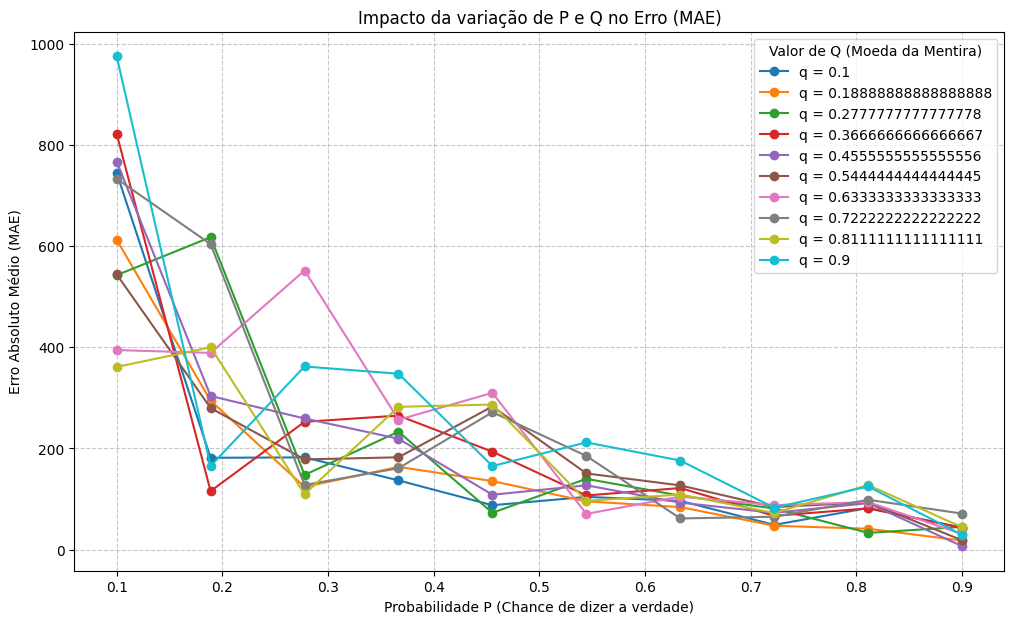

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- 6. Simulação de Variação de P e Q ---
print("Simulando variação de P e Q...")

# Vamos testar 4 valores diferentes para Q
valores_q_teste = np.linspace(0.1, 0.9, 10) 
# Vamos testar uma faixa contínua para P
valores_p_teste = np.linspace(0.1, 0.9, 10)

plt.figure(figsize=(12, 7))

for q_fixo in valores_q_teste:
    maes_por_q = []
    
    for p_teste in valores_p_teste:
        # Executa o experimento 3 vezes para tirar a média e reduzir o acaso
        res = simulacao_rr(p_teste, q_fixo, execucoes=3)
        erro_medio = np.mean([abs(e - valor_real_total) for e in res])
        maes_por_q.append(erro_medio)
        
    # Plota a linha para este valor de Q
    plt.plot(valores_p_teste, maes_por_q, marker='o', label=f'q = {q_fixo}')

plt.title('Impacto da variação de P e Q no Erro (MAE)')
plt.xlabel('Probabilidade P (Chance de dizer a verdade)')
plt.ylabel('Erro Absoluto Médio (MAE)')
plt.legend(title="Valor de Q (Moeda da Mentira)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

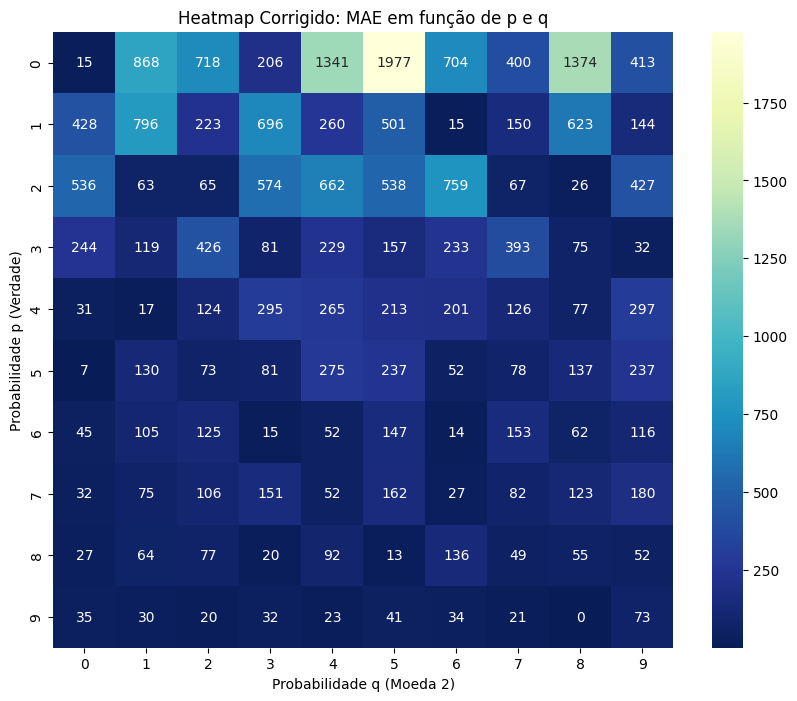

In [18]:
import seaborn as sns # Biblioteca excelente para mapas de calor

def analisar_variacao_p_q(df, passos=10):
    df['income'] = df['income'].str.strip() # LIMPEZA ESSENCIAL
    n = len(df)
    valor_real_total = (df['income'] == '>50K').sum()
    
    lista_p = np.linspace(0.1, 0.9, passos)
    lista_q = np.linspace(0.1, 0.9, passos)
    matriz_erros = np.zeros((passos, passos))

    for i, p in enumerate(lista_p):
        for j, q in enumerate(lista_q):
            # Simulando o RR de forma correta
            def aplicar_rr(x):
                verdade = 1 if x == '>50K' else 0
                if np.random.random() < p: return verdade
                return 1 if np.random.random() < q else 0
            
            respostas = df['income'].apply(aplicar_rr)
            S = respostas.sum()
            T_hat = (S - n * (1 - p) * q) / p
            matriz_erros[i, j] = abs(T_hat - valor_real_total)

    # Plotagem correta
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_erros, annot=True, fmt=".0f", cmap="YlGnBu_r")
    plt.title('Heatmap Corrigido: MAE em função de p e q')
    plt.ylabel('Probabilidade p (Verdade)')
    plt.xlabel('Probabilidade q (Moeda 2)')
    plt.show()
analisar_variacao_p_q(df)    

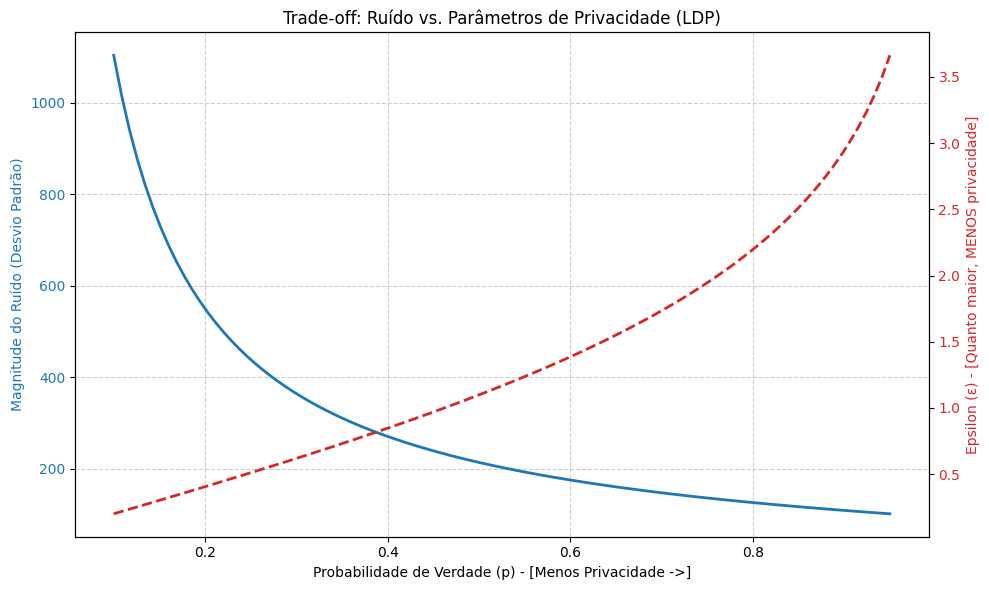

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros baseados no Adult Dataset
n = 48842  # total de registros
T_real = 11687 # valor real aproximado
q = 0.5    # moeda 2 justa

# Variação de p (de muita privacidade/muito ruído para pouca privacidade/pouco ruído)
ps = np.linspace(0.1, 0.95, 100)

def calcular_ruido_teorico(p, n, T, q):
    # A variância do estimador =  magnitude do ruído
    # P_sim = probabilidade de observar 'Sim'
    p_sim = p * (T/n) + (1 - p) * q
    # Variância do estimador
    variancia = (n * p_sim * (1 - p_sim)) / (p**2)
    return np.sqrt(variancia) # Desvio padrão representa a magnitude do ruído

ruidos = [calcular_ruido_teorico(p, n, T_real, q) for p in ps]

# Cálculo do Epsilon (Privacidade Diferencial) para cada p
# Epsilon representa o quão 'sensível' a resposta é em termos de privacidade
epsilons = [np.log((p + (1-p)*q) / ((1-p)*q)) for p in ps]

# Plotagem
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Probabilidade de Verdade (p) - [Menos Privacidade ->]')
ax1.set_ylabel('Magnitude do Ruído (Desvio Padrão)', color=color)
ax1.plot(ps, ruidos, color=color, linewidth=2, label='Magnitude do Ruído')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

# Criar um segundo eixo para mostrar o Epsilon
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Epsilon (ε) - [Quanto maior, MENOS privacidade]', color=color)
ax2.plot(ps, epsilons, color=color, linestyle='--', linewidth=2, label='Privacidade (ε)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Trade-off: Ruído vs. Parâmetros de Privacidade (LDP)')
fig.tight_layout()
plt.show()